In [1]:
import numpy as np
import matplotlib.pyplot as plt

from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("error", category=RuntimeWarning)

from aeons.lm_partial import analytic_lm_params, X_end_formula
from aeons.covariance import X_mu, X_Sigmainv, logX_mu, points_at_iteration
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from aeons.models import LS, CG

#### Functions

In [125]:
from aeons.toy_samples import gaussian_samples
from scipy.special import gammainc, gamma, logsumexp, loggamma
def logZlive(Xi, theta):
    logLmax, d, sigma = theta
    prefactor = logLmax + d/2*np.log(2) + d*np.log(sigma) + np.log(d/2)
    loggammainc = np.log( gammainc( d/2 , Xi**(2/d)/(2*sigma**2) ) * gamma(d/2) )
    return prefactor + loggammainc

def dlogX_calc(logX):
    # Returns dlogX from outside in
    logXp = np.roll(logX, 1)
    logXp[0] = 0
    logXm = np.roll(logX, -1)
    logXm[-1] = -np.inf
    dlogX = np.log(1 - np.exp(logXm-logXp)) + logXp - np.log(2)
    return dlogX

def logZ_trapz(logL, logX):
    dlogX = dlogX_calc(logX)
    return logsumexp(dlogX + logL)

def logXf_formula(logZlive, logZdead, logLmax):
    return logsumexp(logZlive, logZdead - logLmax)

def logXf_formula_gaussian(theta, epsilon=1e-3):
    _, d, sigma = theta
    return d/2*np.log(2) + d * np.log(sigma) + loggamma(1 + d/2) + np.log(epsilon)

def end_iteration(samples, N, epsilon=1e-3):
    iterations = np.linspace(0, len(samples), N).astype(int)
    for ndead in iterations:
        ndead = int(ndead)
        points = points_at_iteration(samples, ndead)
        weights = points.get_weights()
        if weights[ndead:].sum()/weights.sum() < epsilon:
            return ndead

In [145]:
def minimise_bandwidth(logL, X_mean, ndead, alphas, x0):
    theta_best = None
    logZi = -np.inf
    for alpha in alphas:
        startf = int(ndead * (1 - alpha))
        logLf = logL[startf:]
        X_meanf = X_mean[startf:]
        ls = LS(logL, full, X_mean)
        theta = analytic_lm_params(logLf, X_meanf, x0)
        try:
            logZf = ls.logZ(theta)
        except RuntimeWarning:
            print(theta, 'warning', alpha)
            continue
        if logZf > logZi:
            theta_best = theta
    return theta_best

#### **Single iteration**

In [85]:
from aeons.toy_samples import wedding_cake_samples

nlive = 500
d, sigma = 4, 0.01
samples = wedding_cake_samples(nlive, d, sigma)

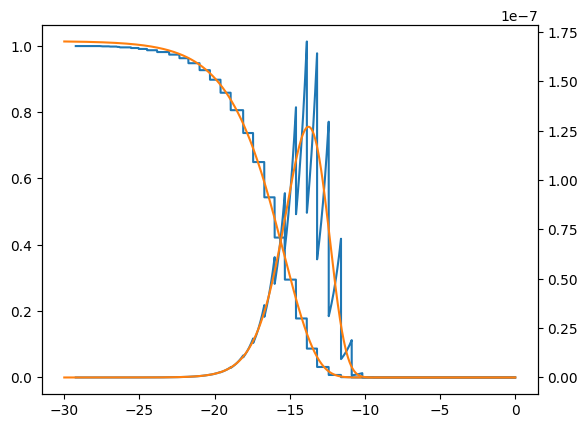

In [6]:
logX = np.array(samples.logX())
logL = np.array(samples.logL)
X = np.exp(logX)
L = np.exp(logL)
theta_l = analytic_lm_params(logL[4000:], X[4000:], 1)

logXarray = np.linspace(-30, 0, 1000)
Xarray = np.exp(logXarray)
logLarray = full.func(Xarray, theta_l)
Larray = np.exp(logLarray)

fig, ax1 = plt.subplots()
ax2 = plt.twinx(ax1)
ax1.plot(logX, L)
ax1.plot(logXarray, Larray)
ax2.plot(logX, L*X)
ax2.plot(logXarray, Larray*Xarray)

In [107]:
iterations = np.arange(100, 8000, 25)
evidences = []
for ndead in iterations:
    points = points_at_iteration(samples, ndead)
    weights = points.get_weights()
    if weights[ndead:].sum()/weights.sum() < 0.001:
        print(ndead)
        break

7675


In [126]:
iterationf = end_iteration(samples, 200)
logXf = samples.logX()[iterationf]
logXf

-21.457810877568157

In [127]:
logXf_formula_gaussian(theta_l)

-21.46202289390123

#### Set up sample

In [155]:
nlive = 500
d, sigma = 10, 0.01
samples = wedding_cake_samples(nlive, d, sigma)

In [158]:
kf = end_iteration(samples, 100)
logXf_true = samples.logX()[kf]

##### Full run - no bandwidth

In [159]:
iterations = np.linspace(0, len(samples), 100, endpoint=False).astype(int)
logXfs = np.zeros_like(iterations)
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    logL = np.array(points.logL)
    nk = np.array(points.nlive)
    X_mean = X_mu(nk)
    theta_l = analytic_lm_params(logL[ndead:], X_mean[ndead:], 1)
    logXfs[i] = logXf_formula_gaussian(theta_l)

(0.0, 15000.0)

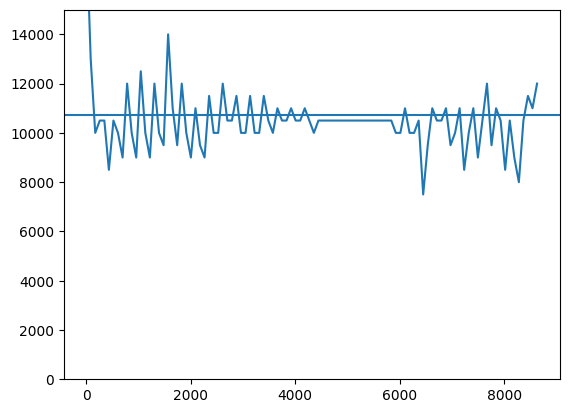

In [160]:
plt.plot(iterations, logXfs * (-nlive))
plt.axhline(logXf_true * (-nlive))
plt.ylim(0, 15000)

##### Full run - bandwidth

In [161]:
iterations = np.linspace(0, len(samples), 100, endpoint=False).astype(int)
logXfs = np.zeros_like(iterations)
alphas = np.linspace(0, 1, 5)
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    logL = np.array(points.logL)
    nk = np.array(points.nlive)
    X_mean = X_mu(nk)
    theta_best = minimise_bandwidth(logL, X_mean, ndead, alphas, 1)
    logXfs[i] = logXf_formula_gaussian(theta_best)

[-93.8265358553652, 2.937881517103526, 0.016341926676535497] warning 0.0
[-106.22019711724283, 3.0196504427595885, 0.016905489018511827] warning 0.25
[-67.96307291553626, 3.5704619543396263, 0.018024984615880306] warning 0.75
[-80.55190784194332, 3.1681014820864, 0.016650864320851312] warning 0.0
[-83.24614042859525, 3.4309075555749873, 0.017941065894920703] warning 0.75
[-63.04638015623186, 3.332746279562574, 0.01729078647892489] warning 0.5
[-61.60068738896541, 3.45496370922474, 0.01774019381152498] warning 0.75
[-60.7373569962831, 3.292975777188648, 0.01699253746415207] warning 0.25
[-82.64650441675371, 3.085146942309188, 0.016807265605596814] warning 0.5
[-56.90756801302712, 3.5027827704917733, 0.017785050641315588] warning 0.75
[-62.65396540098132, 2.9806096605782346, 0.01518717324604196] warning 0.0
[-73.68234607054814, 3.2070030270680348, 0.017082447580914383] warning 0.5
[-46.375583572929855, 2.904079791671914, 0.01368189916638602] warning 0.0
[-36.00832659230096, 3.54627707652

(0.0, 20000.0)

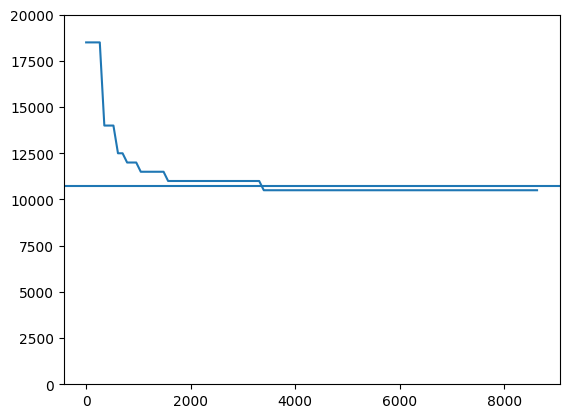

In [162]:
plt.plot(iterations, logXfs * (-nlive))
plt.axhline(logXf_true * (-nlive))
plt.ylim(0, 20000)

##### Full run - errors, no bandwidth

In [207]:
N = 100
iterations = np.linspace(0, len(samples), N, endpoint=False).astype(int)
logXfs = np.zeros(N)
logXfs_std = np.zeros(N)
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    logL = np.array(points.logL)
    nk = np.array(points.nlive)
    logXf_i = []
    for _ in range(10):
        X = generate_Xs(nk)
        theta_l = analytic_lm_params(logL[ndead:], X[ndead:], 1)
        logXf_i.append(logXf_formula_gaussian(theta_l))
    logXfs[i] = np.mean(logXf_i)
    logXfs_std[i] = np.std(logXf_i)

(0.0, 15000.0)

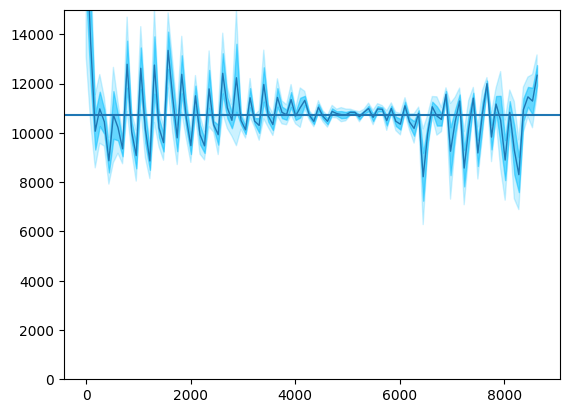

In [208]:
plt.plot(iterations, logXfs * (-nlive), lw=1)
plt.fill_between(iterations, (logXfs - logXfs_std) * (-nlive), (logXfs + logXfs_std) * (-nlive), alpha=0.5, color='deepskyblue')
plt.fill_between(iterations, (logXfs - 2*logXfs_std) * (-nlive), (logXfs + 2*logXfs_std) * (-nlive), alpha=0.2, color='deepskyblue')
plt.axhline(logXf_true * (-nlive))
plt.ylim(0, 15000)

##### Full run - errors, bandwidth

In [203]:
N = 20
iterations = np.linspace(0, len(samples), N, endpoint=False).astype(int)
logXfs = np.zeros(N)
logXfs_std = np.zeros(N)
alphas = np.linspace(0, 1, 5)
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    logL = np.array(points.logL)
    nk = np.array(points.nlive)
    logXf_i = []
    for _ in range(10):
        X = generate_Xs(nk)
        theta_best = minimise_bandwidth(logL, X, ndead, alphas, 1)
        logXf_i.append(logXf_formula_gaussian(theta_best))
    logXfs[i] = np.mean(logXf_i)
    logXfs_std[i] = np.std(logXf_i)

[-107.20141873295461, 2.7896094614079243, 0.015797364378013056] warning 0.0
[-93.12356836858879, 2.9054770425124667, 0.01593971648162115] warning 0.0
[-139.83108608956212, 2.6670764159918985, 0.016739201473125798] warning 0.0
[-111.41221166711728, 3.2006210487885234, 0.018310975277640907] warning 0.5
[-65.66864010531401, 3.591984614987998, 0.018439012792792468] warning 0.75
[-74.87831140526703, 3.1863876259545667, 0.01627279520399036] warning 0.0
[-65.11365764628374, 3.360513320766402, 0.01690380942409857] warning 0.0
[-58.540374621610454, 3.692981201552279, 0.01791180246520226] warning 0.5
[-56.07250509450546, 3.1778492830031, 0.016445254466016274] warning 0.0
[-82.09271671605995, 3.0207258693007715, 0.016482154230345714] warning 0.0
[-96.28286103372773, 2.855447908408161, 0.01610771484077256] warning 0.0
[-64.02611385606724, 3.415400370767434, 0.017557677113396473] warning 0.5
[-88.87131224226465, 2.938629543466018, 0.016366295882256573] warning 0.0
[-80.6691578614404, 3.129844682496

(0.0, 15000.0)

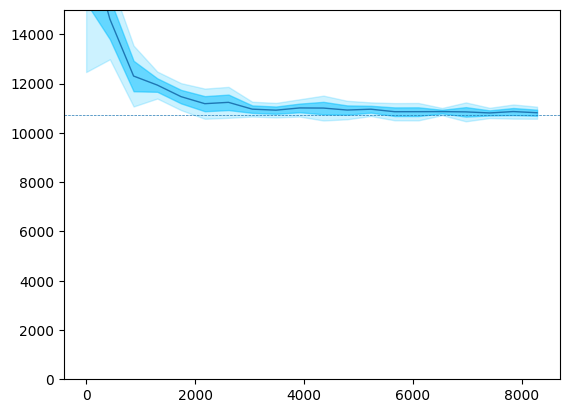

In [204]:
plt.plot(iterations, logXfs * (-nlive), lw=1)
plt.axhline(logXf_true * (-nlive), lw=.5, ls='--')
plt.fill_between(iterations, (logXfs - logXfs_std) * (-nlive), (logXfs + logXfs_std) * (-nlive), alpha=0.5, color='deepskyblue')
plt.fill_between(iterations, (logXfs - 2*logXfs_std) * (-nlive), (logXfs + 2*logXfs_std) * (-nlive), alpha=0.2, color='deepskyblue')
plt.ylim(0, 15000)